# Lectura y Análisis

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [163]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [164]:
# Read the CSV files
directory = "data/"
cuesta_openmetoe_arpege = "openmeteo_cuesta_arpege.csv"
cuesta_openmetoe_icon = "openmeteo_cuesta_icon.csv"

cuesta_grafcan = "grafcan_cuesta.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [cuesta_openmetoe_arpege,
              cuesta_openmetoe_icon,
              cuesta_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_cuesta_arpege.csv...
Processing openmeteo_cuesta_icon.csv...
Processing grafcan_cuesta.csv...


## Visualización

In [165]:
def plot_datasets(datasets, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    # Remove .csv extension if present and check if each dataset is loaded
    dataset_names = [name.replace(".csv", "") for name in datasets]
    for name in dataset_names:
        if name not in dataframes:
            print(f"Dataset '{name}' is not loaded.")
            return

    # Retrieve the dataframes
    dfs = [dataframes[name] for name in dataset_names]

    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=dataset_names)
    
    # Ensure the indicated column exists in every dataset
    for name in dataset_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in dataset_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


### OpenMeteo

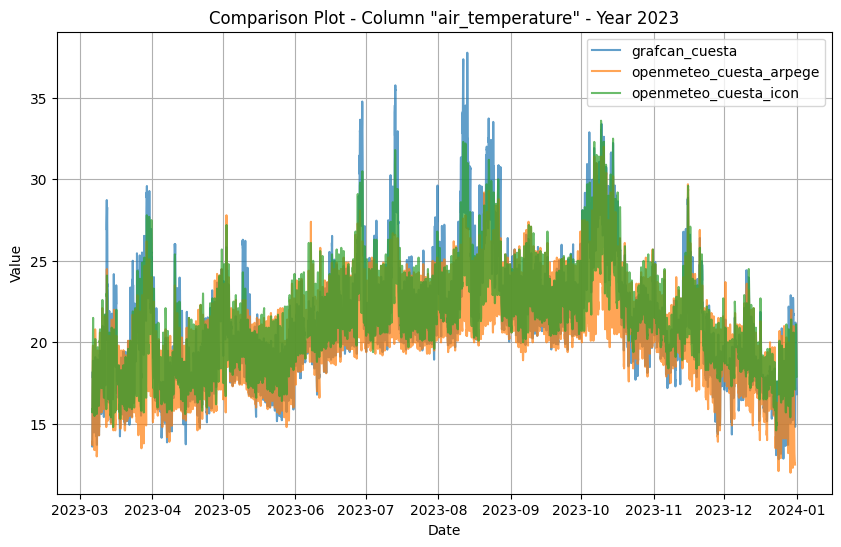

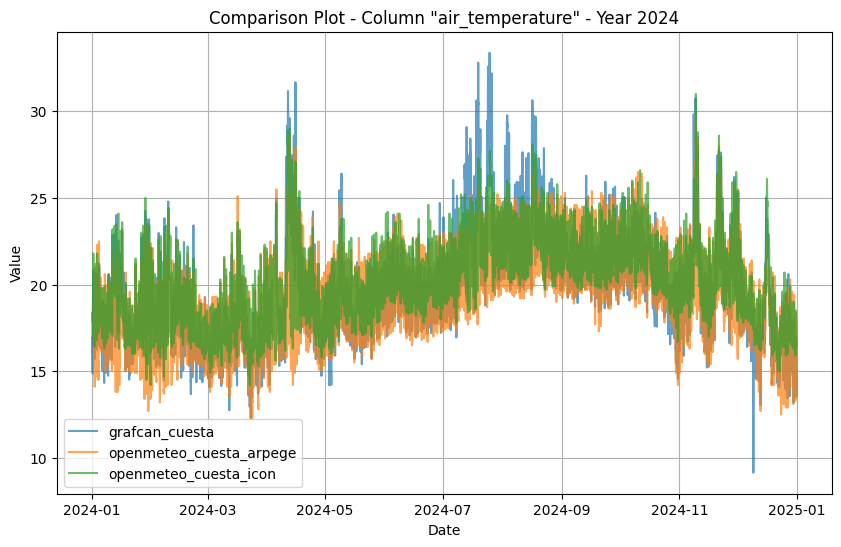

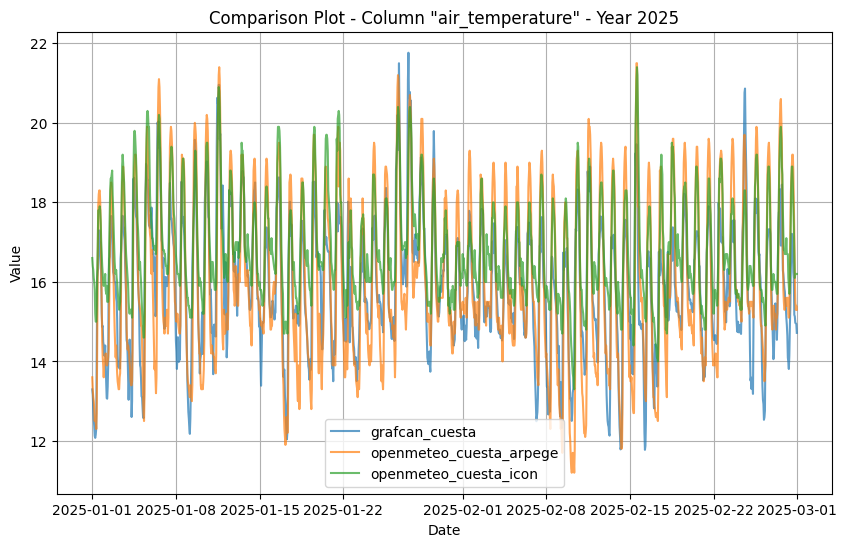

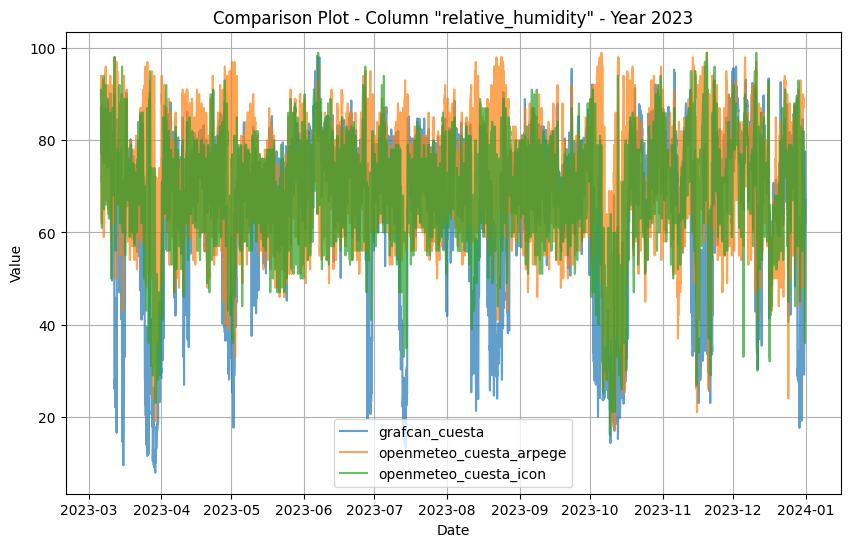

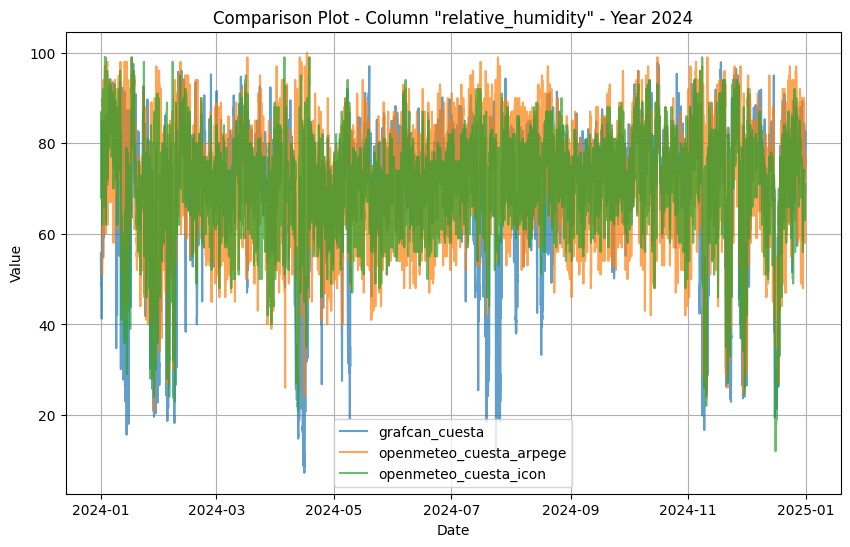

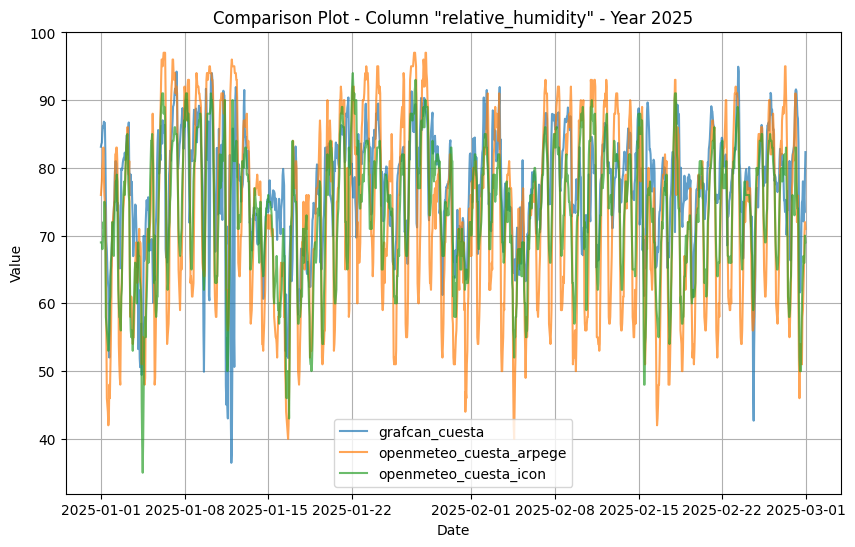

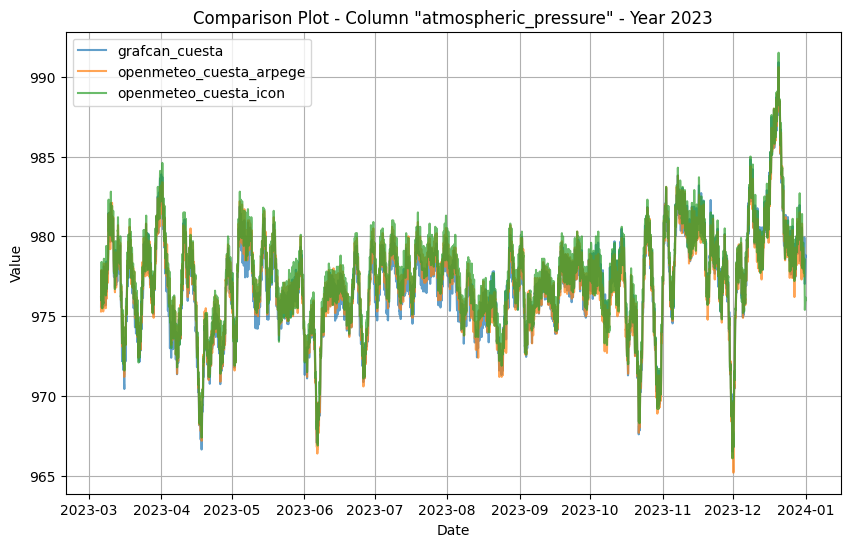

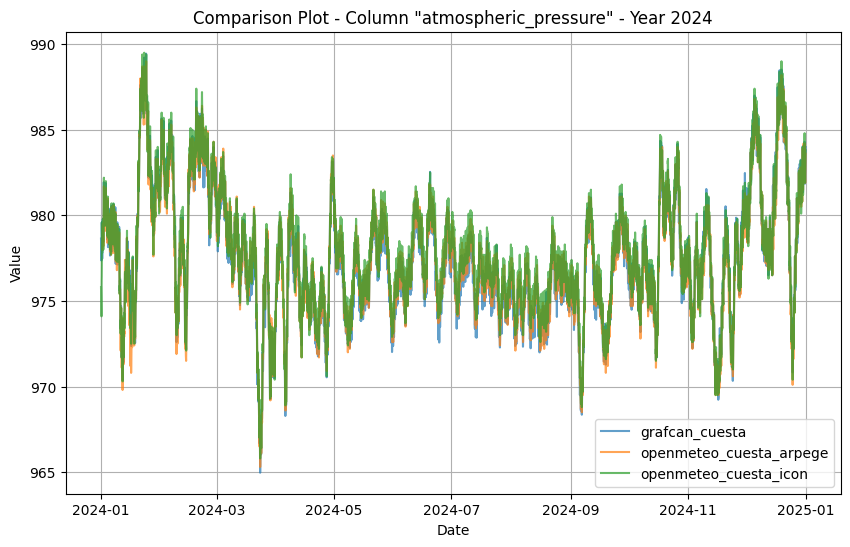

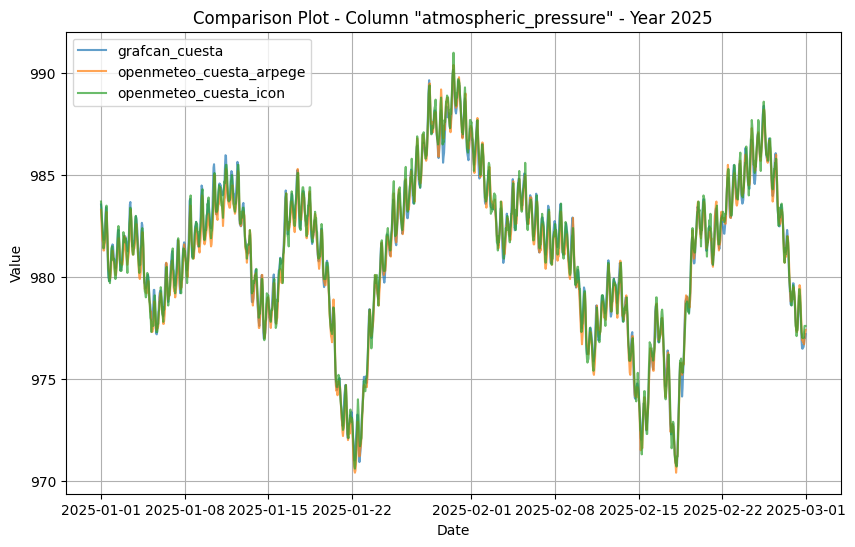

In [166]:
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "air_temperature")
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "relative_humidity")
plot_datasets([cuesta_grafcan, cuesta_openmetoe_arpege, cuesta_openmetoe_icon], "atmospheric_pressure")

## Horas faltantes

In [167]:
    
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_cuesta_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timestamp('2023-12-31 08:00:00+0000', tz='UTC'), Timestamp('2023-12-31 09:00:00+0000', tz='UTC'), Timestamp('2023-12-31 10:00:00+0000', tz='UTC'), Timestamp('2023-12-31 11:00:00+0000', tz='UTC'), Timestamp('2023-12-31 12:00:00+0000', tz='UTC'), Timestamp('2023-12-31 13:00:00+0000', tz='UTC'), Timestamp('2023-12-31 14:00:00+0000', tz='UTC'), Timestamp('2023-12-31 15:00:00+0000', tz='UTC'), Timestamp('2023-12-31 16:00:00+0000', tz='UTC'), Timestamp('2023-12-31 17:00:00+0000', tz='UTC'), Timestamp('2023-12-31 18:00:00+0000', tz='UTC'), Timestamp('2023-12-31 19:00:00+0000', tz='UTC'), Timestamp('2023-12-31 20:00:00+0000', tz='UTC'), Timestamp('2023-12-31 21:00:00+0000', tz='UTC'), Timestamp('2023-12-31 22:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC'), Timestamp('2024-01-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-01 01:00:00+0000', tz='UTC'), Timestamp

### Manejo Horas faltantes

In [168]:
# Cubic Spline Interpolation Algorithm

def pchip_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [169]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    pchip_interpolation(df_hourly)

## Comparativa datasets predicciones

In [170]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [171]:
datasets_similarity(cuesta_openmetoe_icon, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_icon vs grafcan_cuesta
  air_temperature:
    Pearson: 0.9007
    Spearman: 0.9108
    Kendall: 0.7601
    MSE: 2.6470
    Euclidean Distance: 214.7203
  atmospheric_pressure:
    Pearson: 0.9880
    Spearman: 0.9829
    Kendall: 0.8971
    MSE: 0.4914
    Euclidean Distance: 92.5164
  relative_humidity:
    Pearson: 0.5311
    Spearman: 0.5729
    Kendall: 0.4332
    MSE: 206.7749
    Euclidean Distance: 1897.7894


In [172]:
datasets_similarity(cuesta_openmetoe_arpege, cuesta_grafcan)

Similarity Metrics for openmeteo_cuesta_arpege vs grafcan_cuesta
  air_temperature:
    Pearson: 0.8365
    Spearman: 0.8687
    Kendall: 0.7067
    MSE: 4.3758
    Euclidean Distance: 276.0762
  atmospheric_pressure:
    Pearson: 0.9887
    Spearman: 0.9845
    Kendall: 0.9018
    MSE: 0.2930
    Euclidean Distance: 71.4364
  relative_humidity:
    Pearson: 0.3221
    Spearman: 0.4354
    Kendall: 0.3358
    MSE: 319.4494
    Euclidean Distance: 2358.8491


## Detección de outliers



In [173]:
def detect_outliers_iqr(df, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing openmeteo_cuesta_arpege:


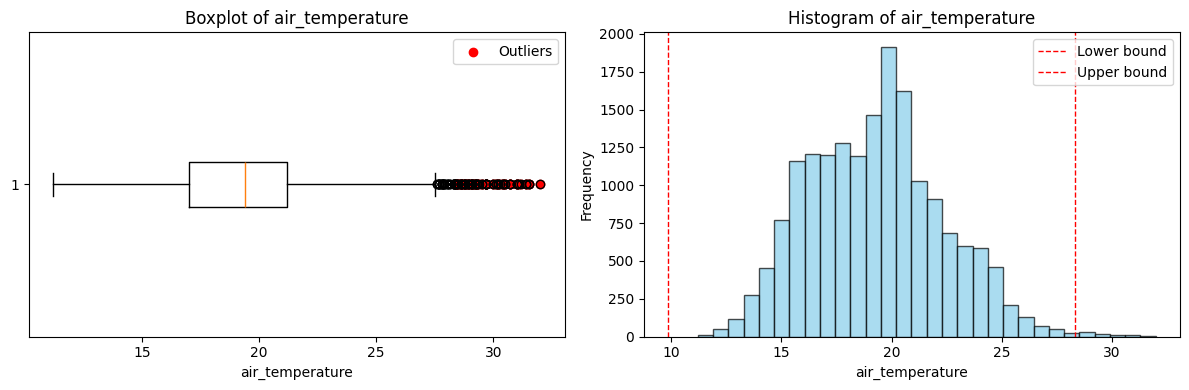

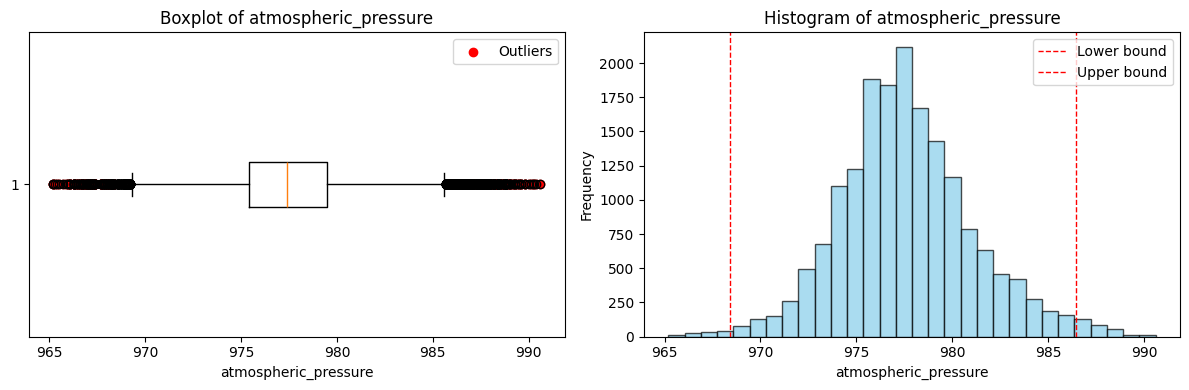

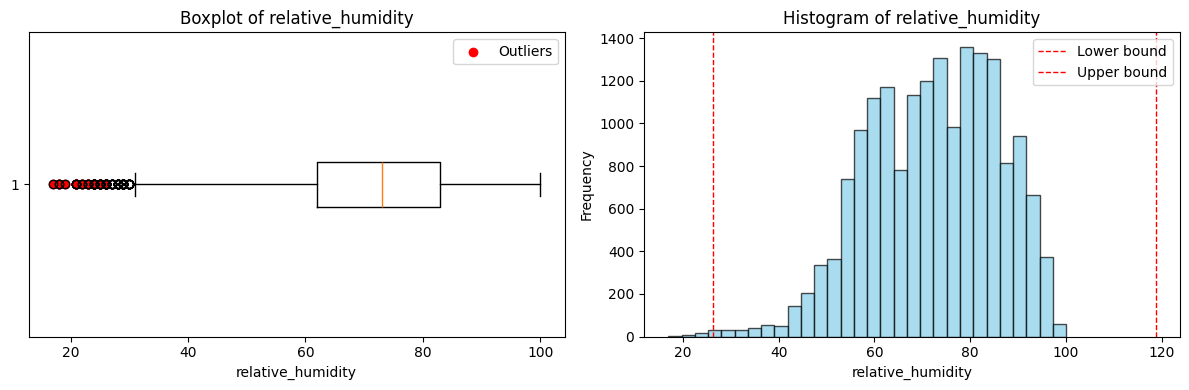

  air_temperature outlier row indices: [Timestamp('2023-08-20 13:00:00+0000', tz='UTC'), Timestamp('2023-08-20 14:00:00+0000', tz='UTC'), Timestamp('2023-08-22 13:00:00+0000', tz='UTC'), Timestamp('2023-08-22 14:00:00+0000', tz='UTC'), Timestamp('2023-08-22 15:00:00+0000', tz='UTC'), Timestamp('2023-08-22 16:00:00+0000', tz='UTC'), Timestamp('2023-08-25 13:00:00+0000', tz='UTC'), Timestamp('2023-08-26 16:00:00+0000', tz='UTC'), Timestamp('2023-08-26 17:00:00+0000', tz='UTC'), Timestamp('2023-10-06 12:00:00+0000', tz='UTC'), Timestamp('2023-10-06 13:00:00+0000', tz='UTC'), Timestamp('2023-10-06 14:00:00+0000', tz='UTC'), Timestamp('2023-10-06 15:00:00+0000', tz='UTC'), Timestamp('2023-10-06 16:00:00+0000', tz='UTC'), Timestamp('2023-10-06 17:00:00+0000', tz='UTC'), Timestamp('2023-10-07 11:00:00+0000', tz='UTC'), Timestamp('2023-10-07 12:00:00+0000', tz='UTC'), Timestamp('2023-10-07 13:00:00+0000', tz='UTC'), Timestamp('2023-10-07 14:00:00+0000', tz='UTC'), Timestamp('2023-10-07 15:00:0

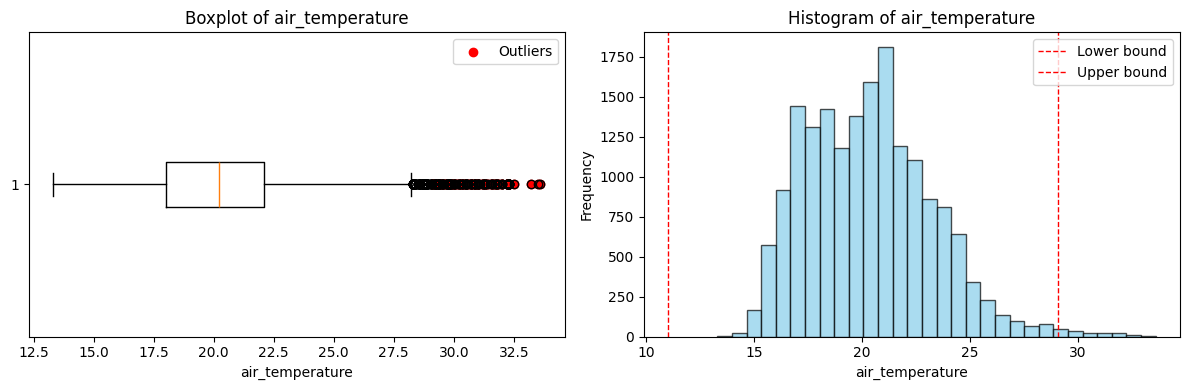

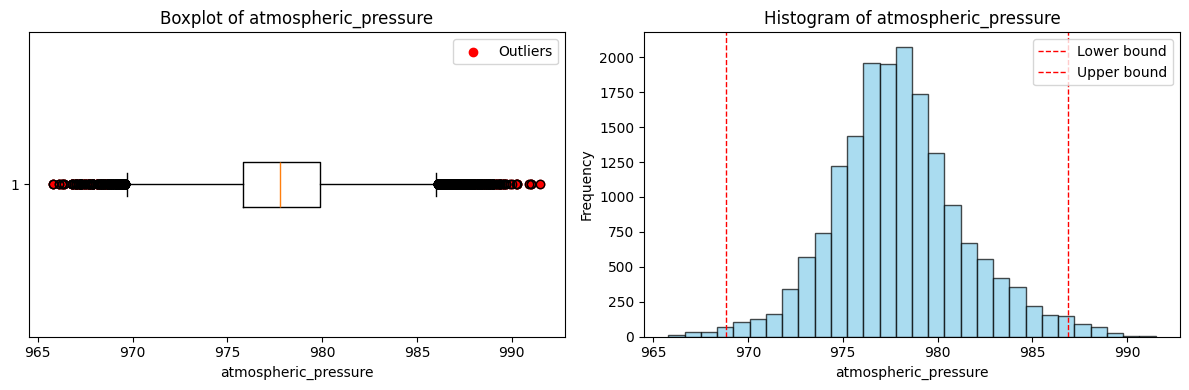

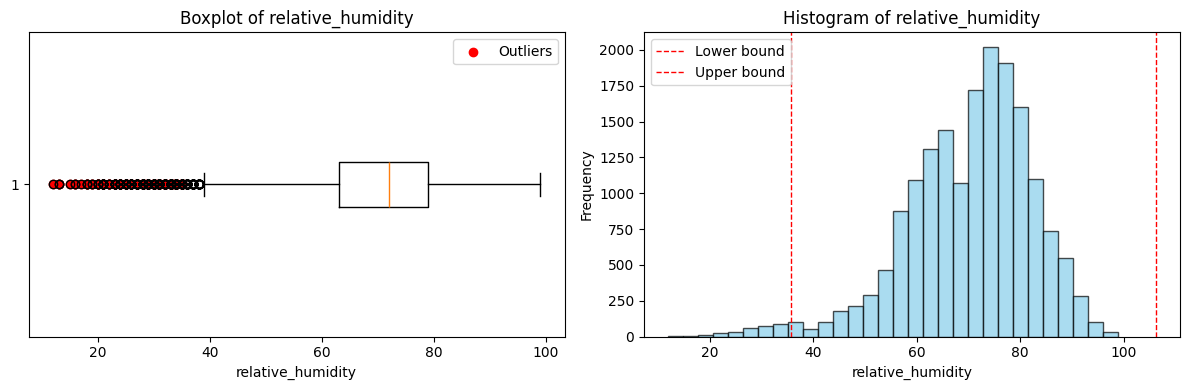

  air_temperature outlier row indices: [Timestamp('2023-06-27 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-06-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-29 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 11:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 15:00:00+0000', tz='UTC'), Timestamp('2023-07-13 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 17:00:00+0000', tz='UTC'), Timestamp('2023-07-13 18:00:00+0000', tz='UTC'), Timestamp('2023-07-14 13:00:0

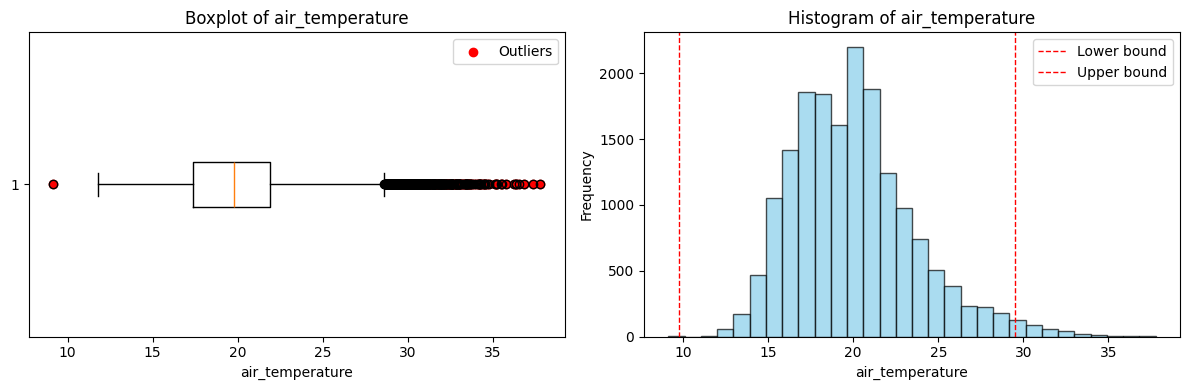

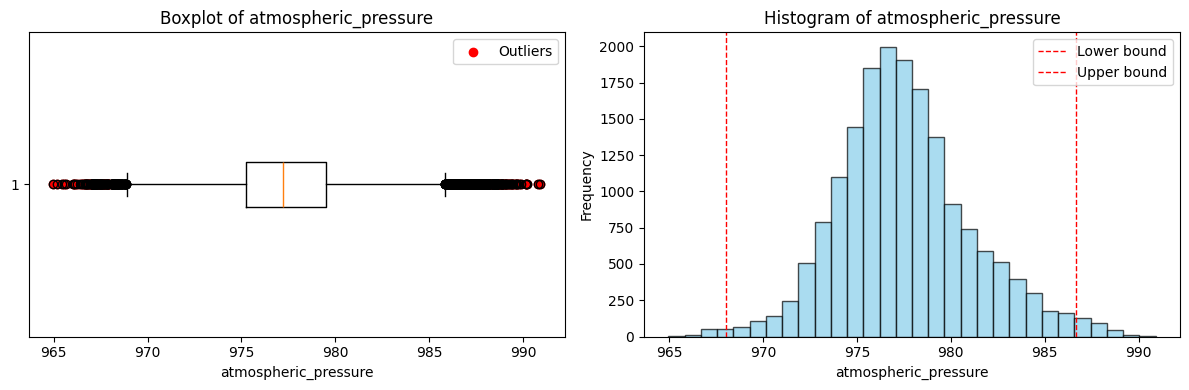

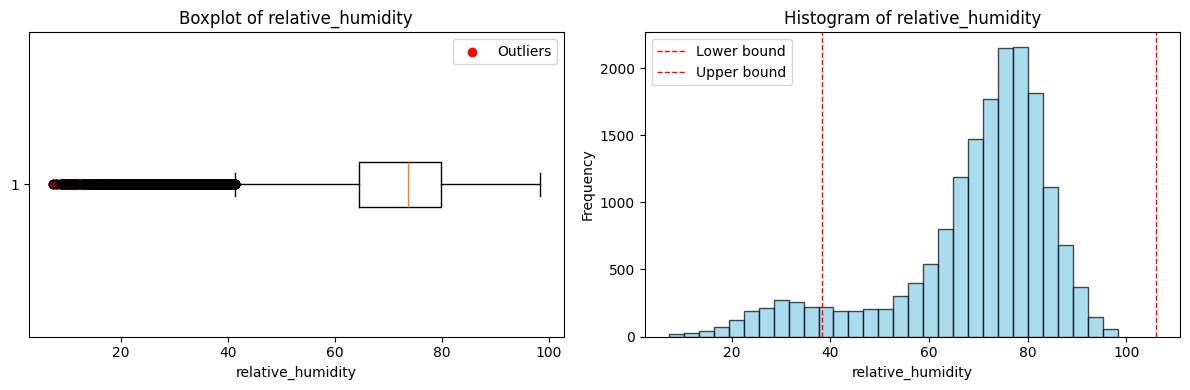

  air_temperature outlier row indices: [Timestamp('2023-03-29 14:00:00+0000', tz='UTC'), Timestamp('2023-03-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 10:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-28 18:00:00+0000', tz='UTC'), Timestamp('2023-06-28 19:00:00+0000', tz='UTC'), Timestamp('2023-06-28 20:00:00+0000', tz='UTC'), Timestamp('2023-06-28 21:00:00+0000', tz='UTC'), Timestamp('2023-06-28 22:00:00+0000', tz='UTC'), Timestamp('2023-06-29 08:00:00+0000', tz='UTC'), Timestamp('2023-06-29 09:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:0

In [174]:
threshold = 1.7

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Removed {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

## Exploración frecuencias - Fourier

In [175]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Top 5 frequencies with highest magnitude:
Frequency: 0.00000024 Hz, Period: 1161.20 hours, Magnitude: 6609.1181
Frequency: 0.00000011 Hz, Period: 2488.29 hours, Magnitude: 6681.5258
Frequency: 0.00000002 Hz, Period: 17418.00 hours, Magnitude: 7671.1708
Frequency: 0.00001158 Hz, Period: 23.99 hours, Magnitude: 14750.5196
Frequency: 0.00000003 Hz, Period: 8709.00 hours, Magnitude: 27399.5557


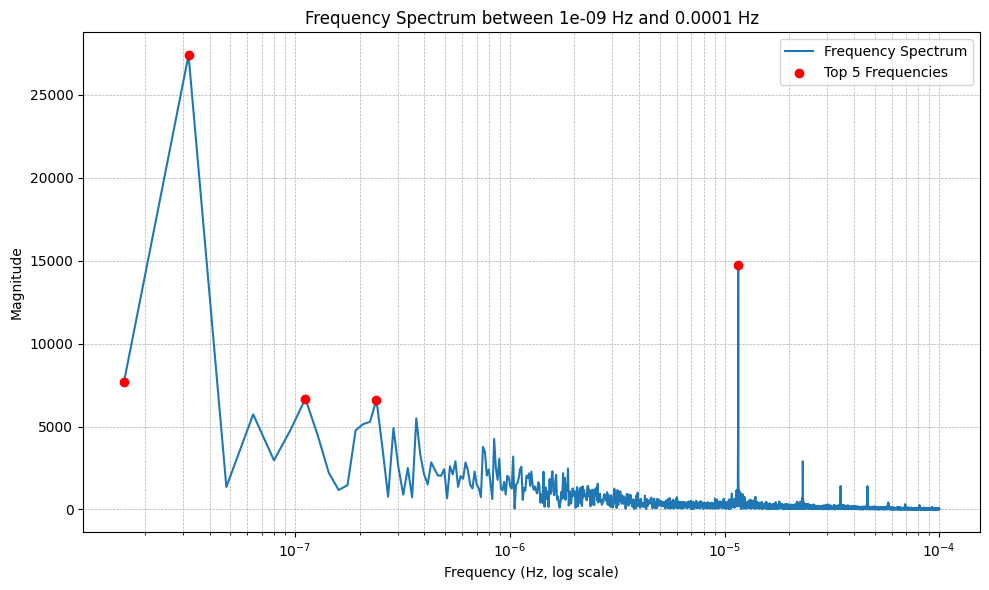

Top 5 frequencies with highest magnitude:
Frequency: 0.00000002 Hz, Period: 17418.00 hours, Magnitude: 31173.2671
Frequency: 0.00000029 Hz, Period: 967.67 hours, Magnitude: 33224.2396
Frequency: 0.00000011 Hz, Period: 2488.29 hours, Magnitude: 34532.4697
Frequency: 0.00001158 Hz, Period: 23.99 hours, Magnitude: 35607.2186
Frequency: 0.00000024 Hz, Period: 1161.20 hours, Magnitude: 38769.7675


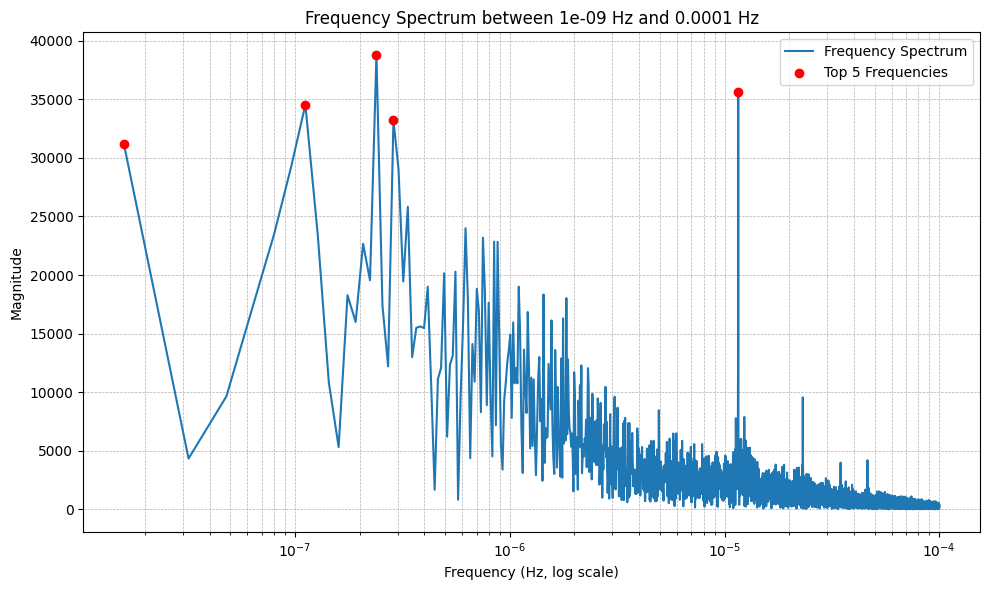

Top 5 frequencies with highest magnitude:
Frequency: 0.00000016 Hz, Period: 1741.80 hours, Magnitude: 6691.0651
Frequency: 0.00000030 Hz, Period: 916.74 hours, Magnitude: 6719.0644
Frequency: 0.00000032 Hz, Period: 870.90 hours, Magnitude: 7736.3180
Frequency: 0.00000006 Hz, Period: 4354.50 hours, Magnitude: 11474.2938
Frequency: 0.00000003 Hz, Period: 8709.00 hours, Magnitude: 19932.2707


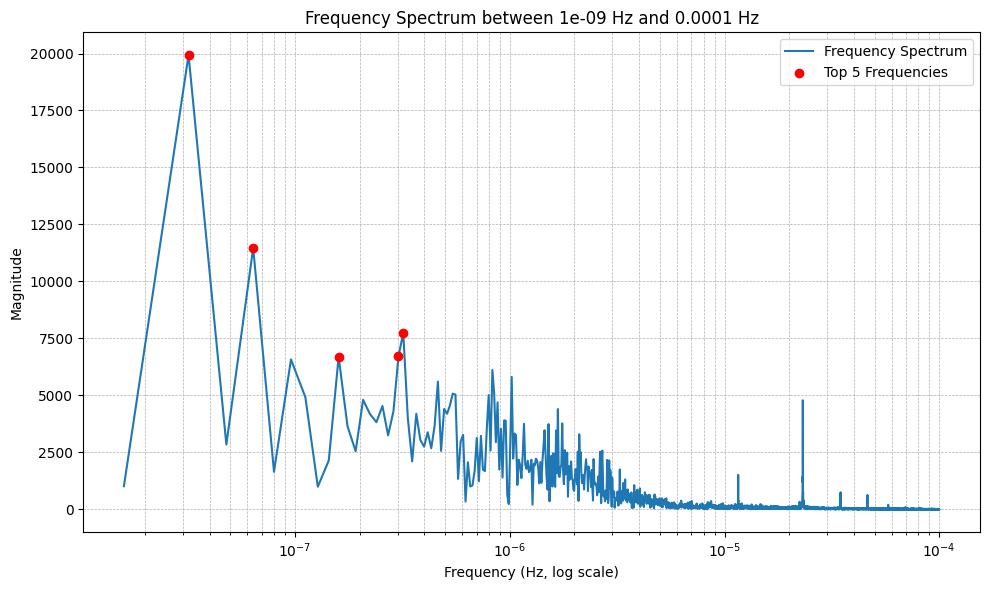

In [176]:


min_frequency = 10**-9
max_frequency = 10**-4
top_n = 5

plot_frequencies(dataframes["grafcan_cuesta"], "air_temperature", min_frequency, max_frequency, top_n)
plot_frequencies(dataframes["grafcan_cuesta"], "relative_humidity", min_frequency, max_frequency, top_n)
plot_frequencies(dataframes["grafcan_cuesta"], "atmospheric_pressure", min_frequency, max_frequency, top_n)



## Creación Dataset Entrenamiento

In [177]:
import keras
import tensorflow as tf

df = dataframes["grafcan_cuesta"].copy()
df.index.name = "time"
df.reset_index(inplace=True)

# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]
print(df.iloc[first_2025_day_index])

###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

features = df.drop(columns="time")
features.index = df["time"]
normalized_features, mean, std = normalize(features.values, first_2025_day_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)
print("Normalized: ", normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_day_index]
val_data = normalized_features.loc[first_2025_day_index:]

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST

# Labels start after past data
label_start = past
label_end = label_start + first_2025_day_index

x_train = train_data
y_train = normalized_features.iloc[label_start:label_end]
y_train_multi = np.array([y_train[i:i+future] for i in range(len(y_train) - future + 1)])

# Validation data structure #
#############################
x_val_end = len(val_data) - past - future
val_label_start = first_2025_day_index + past

x_val = val_data.iloc[:x_val_end]
y_val = normalized_features.iloc[val_label_start:]
y_val_multi = np.array([y_val[i:i+future] for i in range(len(y_val) - future + 1)])

# Parameters #
##############
learning_rate = 0.001
batch_size = 256
epochs = 10
step = 1 

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

tf.data.Dataset.save(dataset_train, "dataset_train")
tf.data.Dataset.save(dataset_val, "dataset_val")


for batch_x, batch_y in dataset_train.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy())
    print("First batch Y:", batch_y.numpy())



time                    2025-01-01 00:00:00+00:00
air_temperature                         13.296237
atmospheric_pressure                   983.553589
relative_humidity                        83.11875
Name: 16002, dtype: object
Normalized:     air_temperature  atmospheric_pressure  relative_humidity
0        -1.857853             -0.477118           1.104425
1        -1.934115             -0.334410           0.996726
2        -1.526210             -0.145579           0.790753
3        -0.733688             -0.016453           0.523589
4        -0.729864              0.083493           0.635934
First batch X: [[[-1.85785263 -0.47711751  1.10442501]
  [-1.93411478 -0.33441034  0.99672616]
  [-1.52621021 -0.14557886  0.79075278]
  ...
  [-0.63278778  0.02072166  0.390793  ]
  [-0.79394777  0.11834876  0.7902734 ]
  [-0.65185204  0.27486689  0.82972224]]

 [[-1.93411478 -0.33441034  0.99672616]
  [-1.52621021 -0.14557886  0.79075278]
  [-0.73368756 -0.01645261  0.52358942]
  ...
  [-0.79394

In [178]:
mean

array([ 20.370146  , 977.20317356,  68.47096018])

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)     │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 30, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 9)              │           153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_50 (Reshape)            │ (None, 3, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,897 (30.85 KB)

 Trainable params: 7,897 (30.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9472
Epoch 1: val_loss improved from inf to 0.98811, saving model to model_checkpoint.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.9431 - val_loss: 0.9881
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6690
Epoch 2: val_loss improved from 0.98811 to 0.63084, saving model to model_checkpoint.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.6676 - val_loss: 0.6308
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5119
Epoch 3: val_loss improved from 0.63084 to 0.43955, saving model to model_checkpoint.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5109 - val_loss: 0.4395
Epoch 4/100
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4238
Epoch 4: val_loss improved from 0.43955 to 0.34383, saving model to model_checkpoint.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4222 - val_loss: 0.3438
Epoch 5/100
61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

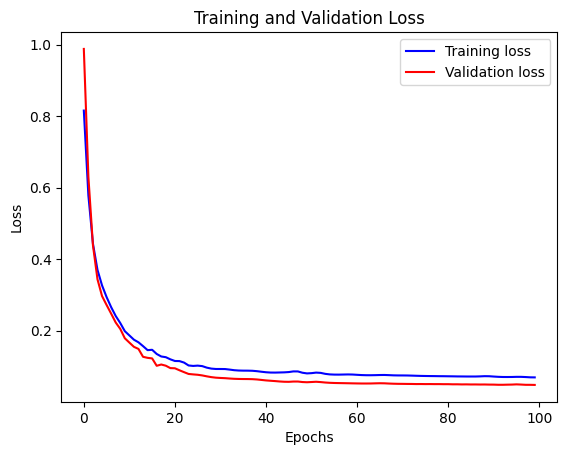

In [190]:
############
# Training #
epochs = 100

dataset_train = tf.data.Dataset.load("dataset_train")
dataset_val = tf.data.Dataset.load("dataset_val")

for batch in dataset_train.take(1):
    inputs, targets = batch

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# lstm_out = keras.layers.LSTM(48)(inputs)
lstm_out = keras.layers.LSTM(32, return_sequences=True)(inputs)
lstm_out = keras.layers.LSTM(16)(lstm_out)
# Ensure the Dense layer outputs the correct shape
output_units = targets.shape[1] * targets.shape[2]  # Flatten output shape
outputs = keras.layers.Dense(output_units)(lstm_out)

# Reshape to match the target shape
outputs = keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


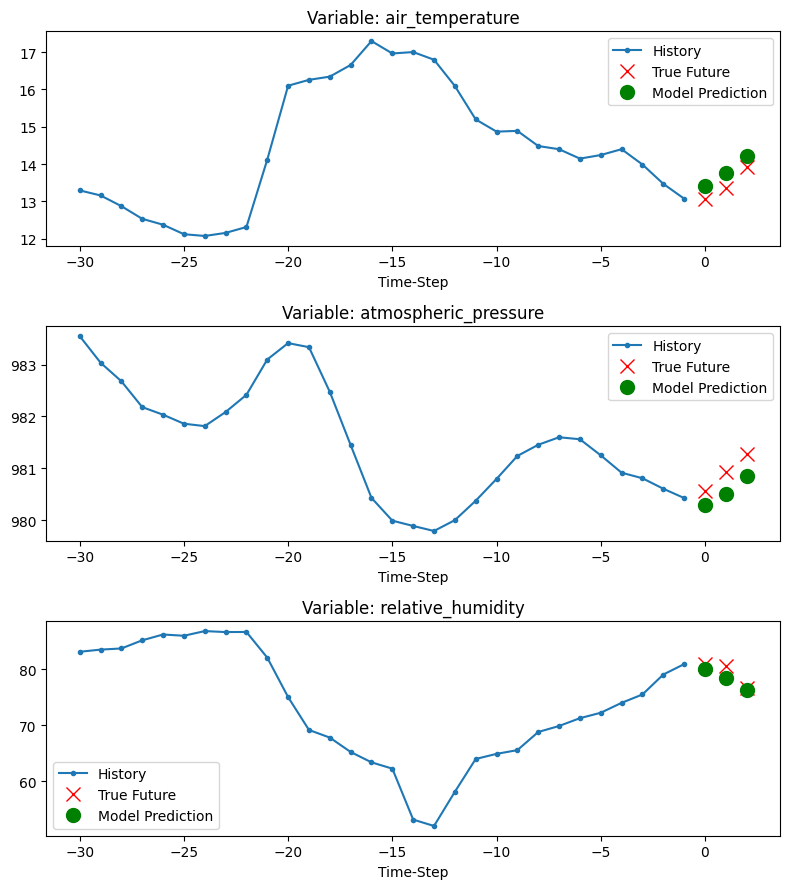

In [191]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = plot_data[0].shape[1]  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, i] * std[i] + mean[i]
        true_future = plot_data[1][:, i] * std[i] + mean[i]
        prediction = plot_data[2][:, i] * std[i] + mean[i]

        time_steps = list(range(-len(history), 0))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta, delta + len(true_future)))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = features.columns  # Modify if real names exist

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in dataset_val.take(1):
    prediction = model.predict(x)
    show_plots_for_variables([x[0].numpy(), y[0].numpy(), prediction[0]], 0, feature_names, mean, std)



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


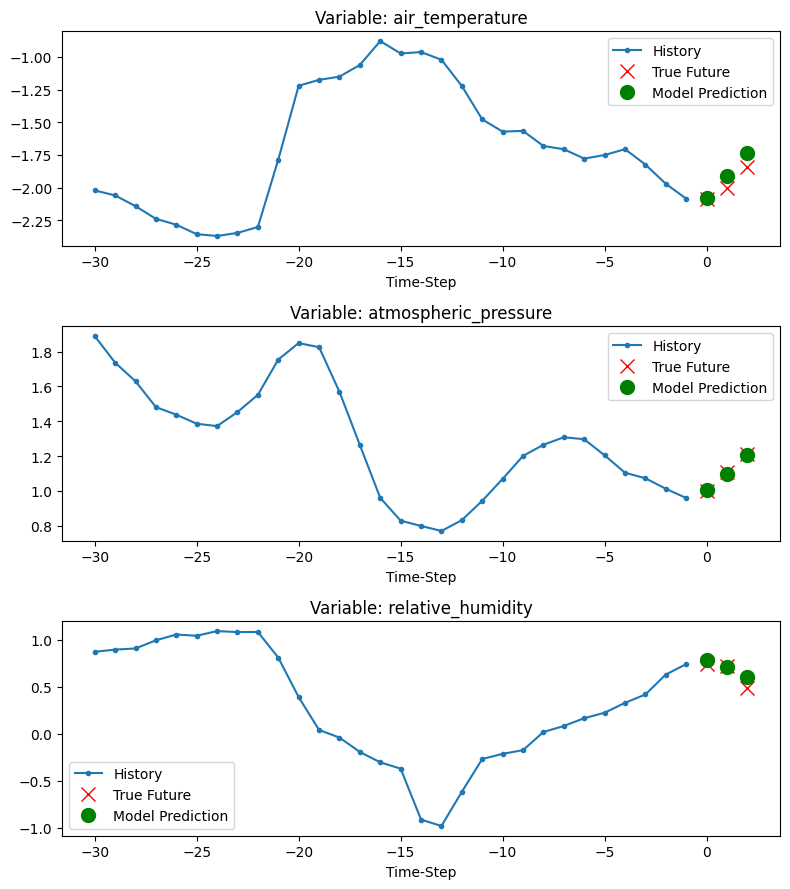

In [181]:
def show_plots_for_variables(plot_data, delta, feature_names):
    """
    Plots separate graphs for each variable, showing the 3 forecast points.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = plot_data[0].shape[1]  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]
        history = plot_data[0][:, i].flatten()  # Extract history for variable i
        time_steps = list(range(-len(history), 0))

        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        for j in range(1, len(plot_data)):
            forecast = plot_data[j][:, i].flatten()
            forecast_time = list(range(delta, delta + len(forecast)))
            ax.plot(forecast_time, forecast, markers[j], markersize=10, label=labels[j])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names =  features.columns # Modify if real names exist

# Plot for a single batch
for x, y in dataset_val.take(1):
    prediction = model.predict(x)
    show_plots_for_variables([x[0].numpy(), y[0].numpy(), prediction[0]], 0, feature_names)

## Escritura fichero 

In [182]:
for file_key, df_hourly in dataframes.items():
  print(df_hourly.describe())

       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         19.294836            977.612579          72.196534
std           3.059886              3.502608          13.579603
min          11.200000            965.200000          17.000000
25%          17.000000            975.400000          62.000000
50%          19.400000            977.400000          73.000000
75%          21.200000            979.500000          83.000000
max          32.000000            990.600000         100.000000
       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         20.314284            977.968377          70.283003
std           2.927863              3.472214          12.131911
min          13.300000            965.800000          12.000000
25%          18.000000            975.800000          63.000000
50%          20.200000            977.80